In [1]:
!tar -xf ILSVRC.tar

In [2]:
!ls ILSVRC/

Annotations  Data  ImageSets


In [3]:
!ls ILSVRC/Data/CLS-LOC/
!ls ILSVRC/ImageSets/CLS-LOC/


train  val
train_cls.txt  val.txt


In [4]:
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os

class ImageNetVal(Dataset):
    def __init__(self, val_dir, val_txt_path, transform=None):
        self.val_dir = val_dir
        self.transform = transform

        # Read val.txt to create mapping
        self.samples = []
        with open(val_txt_path, 'r') as f:
            for line in f:
                img_name, class_idx = line.strip().split()
                img_path = os.path.join(val_dir, img_name + '.JPEG')
                self.samples.append((img_path, int(class_idx) - 1))  # Convert to 0-indexed

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)

        if self.transform is not None:
            img = self.transform(image=img)["image"]

        return img, label


In [6]:
# Wrapper for training data to use Albumentations
class AlbuImageNet(Dataset):
    def __init__(self, imagefolder_ds, transform=None):
        self.ds = imagefolder_ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        img = np.array(img)
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        return img, label

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import os

# ImageNet normalization stats (standard for ImageNet-based datasets)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Convert to 0..255 for fill_value
fill_value_255 = tuple(int(m * 255) for m in MEAN)

def get_train_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.10, rotate_limit=15, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
        A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
                        min_holes=1, min_height=int(image_size*0.25), min_width=int(image_size*0.25),
                        fill_value=fill_value_255, p=0.5),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

def get_val_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

In [7]:
def get_dataloaders_imagenet(data_path, batch_size=256, image_size=224, num_workers=4):
    """
    Create train and validation dataloaders for ImageNet

    Args:
        data_path: Path to ILSVRC directory (contains Data/ and ImageSets/)
        batch_size: Batch size for training
        image_size: Target image size
        num_workers: Number of worker processes
    """
    train_tfms = get_train_transforms(image_size)
    val_tfms = get_val_transforms(image_size)

    # Training data - use ImageFolder (already organized by synsets)
    train_dir = os.path.join(data_path, 'Data', 'CLS-LOC', 'train')
    train_ds = datasets.ImageFolder(train_dir)
    # Wrap with Albumentations
    train_ds_albu = AlbuImageNet(train_ds, transform=train_tfms)

    # Validation data - use custom dataset
    val_dir = os.path.join(data_path, 'Data', 'CLS-LOC', 'val')
    val_txt = os.path.join(data_path, 'ImageSets', 'CLS-LOC', 'val.txt')
    val_ds = ImageNetVal(val_dir, val_txt, transform=val_tfms)

    train_loader = DataLoader(train_ds_albu, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True, persistent_workers=True)

    return train_loader, val_loader

In [10]:
# Test the ImageNet dataloader
data_path = 'ILSVRC'
train_loader, val_loader = get_dataloaders_imagenet(data_path, batch_size=2, image_size=224, num_workers=4)

# Check if it works
imgs, labels = next(iter(train_loader))
print("Train batch shape:", imgs.shape, "Labels:", labels)

imgs, labels = next(iter(val_loader))
print("Val batch shape:", imgs.shape, "Labels:", labels)

/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train batch shape: torch.Size([2, 3, 224, 224]) Labels: tensor([1, 1])
Val batch shape: torch.Size([2, 3, 224, 224]) Labels: tensor([0, 1])


In [11]:
# Peek a batch and verify normalization stats roughly centered
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape, "| dtype:", imgs.dtype, "| range ~", (imgs.min().item(), imgs.max().item()))
print("Per-channel mean (batch):", imgs.mean(dim=(0,2,3)))
print("Per-channel std  (batch):", imgs.std(dim=(0,2,3)))

Batch shape: torch.Size([2, 3, 224, 224]) | dtype: torch.float32 | range ~ (-2.1179039478302, 2.6399998664855957)
Per-channel mean (batch): tensor([0.0773, 0.2135, 0.1015])
Per-channel std  (batch): tensor([0.9621, 0.9307, 1.0464])


In [12]:
# Utils to denormalize and visualize a small grid of images
import math
import torch
import matplotlib.pyplot as plt

# Use MEAN/STD computed earlier (lists) and make tensors for broadcasting
_MEAN = torch.tensor(MEAN).view(1, 3, 1, 1)
_STD  = torch.tensor(STD).view(1, 3, 1, 1)

def denorm(imgs):
    """imgs: tensor [B,C,H,W] normalized with MEAN/STD -> return in [0,1]"""
    x = imgs.clone().cpu()
    x = x * _STD + _MEAN
    return x.clamp(0.0, 1.0)

def show_batch(images, labels, class_names, n=16, cols=8):
    """
    Show n images with titles (class names) in a grid.
    images: [B,C,H,W] tensor (normalized)
    labels: [B] tensor
    """
    n = min(n, images.size(0))
    rows = math.ceil(n / cols)
    imgs = denorm(images[:n])

    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i in range(n):
        img = imgs[i].permute(1, 2, 0).numpy()  # HWC
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(class_names[int(labels[i])], fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [31]:
# Training data - use ImageFolder (already organized by synsets)
train_dir = os.path.join(data_path, 'Data', 'CLS-LOC', 'train')
train_ds = datasets.ImageFolder(train_dir)
train_loader, val_loader = get_dataloaders_imagenet(data_path, batch_size=5, image_size=224, num_workers=4)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [20]:
train_ds.classes

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


5


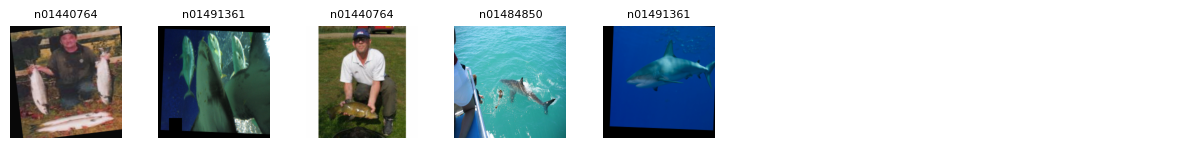

In [32]:
import matplotlib.pyplot as plt

class_names = train_ds.classes


def show_batch(images, labels, class_names, n=16, cols=8):
    """Display a batch of images with their labels."""
    n = min(n, len(images))
    print(n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()  # CHW -> HWC
        img = img * np.array(STD) + np.array(MEAN)  # denormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]], fontsize=8)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display batch
train_images, train_labels = next(iter(train_loader))
show_batch(train_images, train_labels, class_names, n=16, cols=8)


In [30]:
train_labels

tensor([0, 1])

5


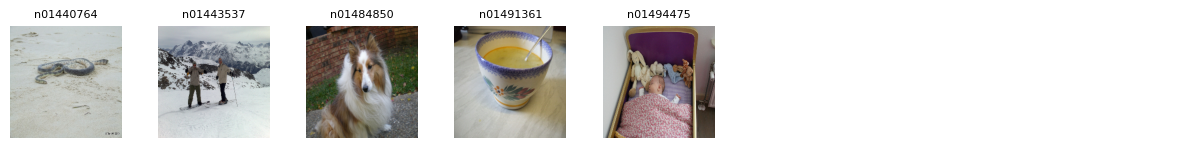

In [33]:
val_images, val_labels = next(iter(val_loader))
show_batch(val_images, val_labels, class_names, n=16, cols=8)